# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [12]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
df.shape

(7591, 2)

In [4]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


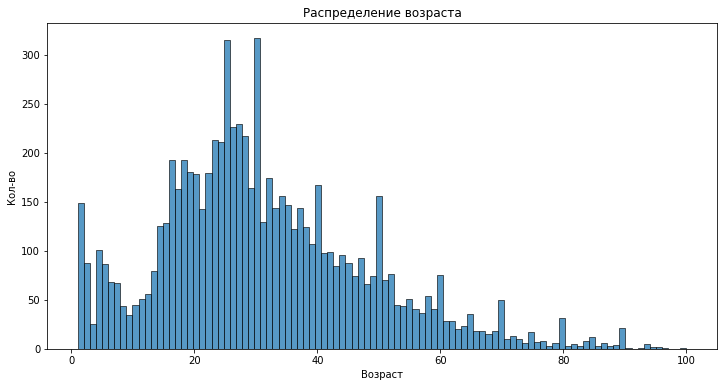

In [15]:
plt.figure(figsize=(12, 6))


sns.histplot(df['real_age'], bins=100, kde=False)

plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Кол-во')


plt.show();

In [16]:
datagen = ImageDataGenerator(
    rescale=1/255.
)

datagen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


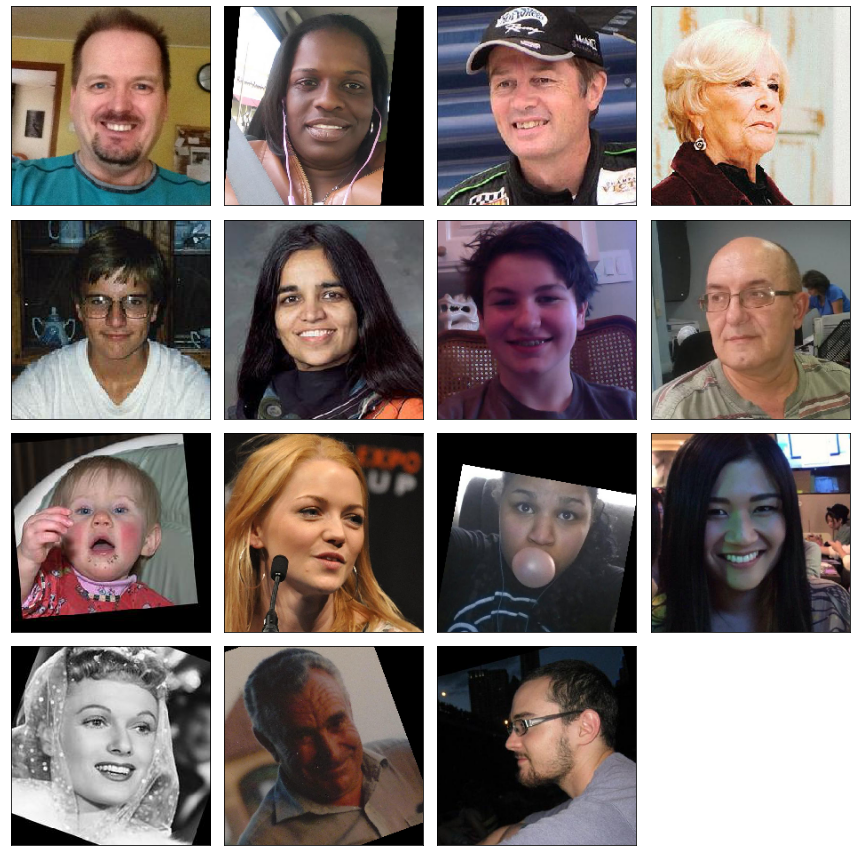

In [17]:
features, target = next(datagen_flow)

fig = plt.figure(figsize=(12,12))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод по исследовательскому анализу


В датасете 7591 фотографи. Диапазон возраста от 20 до 41 года. В выборке есть дети и пожилые личности. С учетом вложенных фотографий модели будет непросто оценивать возраст. На фотографиях присутствуют объекты, которые закрывают лицо: рука, жвачка, очки, головной убор и т.д.

## Обучение модели

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Dropout, AveragePooling2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_train(path):
    df = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.
    )
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = df,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode = 'raw',
        subset='training',
        seed=12345
    )
    
    return train_datagen_flow


def load_test(path):
    df = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.
    )
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = df,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    
    return test_datagen_flow



def create_model(input_shape):
    base_model = ResNet50(weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                          include_top=False, input_shape=input_shape)
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    # Обучение модели
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size, epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    return model


```

Вывод консоли

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.


356/356 - 78s - loss: 215.3535 - mae: 10.5278 - val_loss: 458.9940 - val_mae: 16.2368
Epoch 2/10
356/356 - 48s - loss: 68.3696 - mae: 6.3053 - val_loss: 150.8022 - val_mae: 9.5634
Epoch 3/10
356/356 - 52s - loss: 38.0227 - mae: 4.7542 - val_loss: 75.4582 - val_mae: 6.6334
Epoch 4/10
356/356 - 52s - loss: 25.2879 - mae: 3.8755 - val_loss: 82.2478 - val_mae: 6.9924
Epoch 5/10
356/356 - 49s - loss: 17.8293 - mae: 3.2796 - val_loss: 73.3017 - val_mae: 6.4161
Epoch 6/10
356/356 - 50s - loss: 14.4330 - mae: 2.8826 - val_loss: 70.8205 - val_mae: 6.3366
Epoch 7/10
356/356 - 52s - loss: 11.6857 - mae: 2.6166 - val_loss: 78.6743 - val_mae: 6.6438
Epoch 8/10
356/356 - 52s - loss: 11.1247 - mae: 2.5217 - val_loss: 77.0201 - val_mae: 6.6994
Epoch 9/10
356/356 - 47s - loss: 10.4657 - mae: 2.4655 - val_loss: 93.6618 - val_mae: 7.2301
Epoch 10/10
356/356 - 53s - loss: 10.5243 - mae: 2.4783 - val_loss: 81.6671 - val_mae: 6.7460

119/119 - 12s - loss: 81.6671 - mae: 6.7460

```

Модель построена на ResNet50

за 10 эпох мы уменьшели `MAE` с 17 до 6.74. Задача выполнена

## Анализ обученной модели

Модель на основе **`ResNet50`** успешно обучена для определения возраста покупателей с погрешностью 6 лет `(MAE 6.74)`. Использование предобученной модели, аугментации данных и 10 эпох обучения позволило достичь высокой точности без переобучения. Модель готова к внедрению в систему супермаркета для анализа возраста и улучшения обслуживания клиентов. Для дальнейшего улучшения можно увеличить объем данных, использовать более мощные архитектуры или настроить гиперпараметры.
